In [1]:
#!pip install pandas
#!pip install pydicom
#!pip install tqdm
#!pip install matplotlib

In [2]:
import os
import shutil
from os import listdir
from os.path import isfile, join
import glob

import pandas as pd
import numpy as np
import pydicom
import matplotlib.pylab as plt
from PIL import Image
from tqdm import tqdm

tqdm.pandas()

DATASET_DIR = '/media/paulo/Backup/rsna-intracranial-hemorrhage-detection/'
train_images_dir = DATASET_DIR + 'stage_2_train/'
CSV_FILENAME = DATASET_DIR + 'stage_2_train.csv'

print('Reading annotation csv')
df = pd.read_csv( CSV_FILENAME)

print('Listing Image Folder')
train_images = [f for f in tqdm(listdir(train_images_dir)) if isfile(join(train_images_dir, f))]
print('Number of train images:', len(train_images))

Reading annotation csv
Listing Image Folder


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 752803/752803 [00:01<00:00, 482212.52it/s]

Number of train images: 752803


### Checks if the dataset has duplicated data

In [3]:
print("Checking for duplicates...")
duplicates = df[df.duplicated()]
if not duplicates.empty:
    print(f"Found {duplicates.shape[0]} duplicates!")
else:
    print("No duplicates found!")

Checking for duplicates...
Found 24 duplicates!


### Aggregates data based on the combination of image_id and hemorrhage_type

In [4]:
# Extracting image ID and hemorrhage type from the ID column
df['image_id'] = df['ID'].apply(lambda x: "_".join(x.split('_')[:-1]))
df['hemorrhage_type'] = df['ID'].apply(lambda x: x.split('_')[-1])

# Aggregating data
df = df.groupby(['image_id', 'hemorrhage_type']).agg({'Label': 'max'}).reset_index()
df = df.pivot(index='image_id', columns='hemorrhage_type', values='Label').reset_index()
df.columns.name = None

# Renaming the 'any' column to 'normal'
df.rename(columns={'any': 'normal'}, inplace=True)
df

image_id  normal  epidural  intraparenchymal  intraventricular  \
0       ID_000012eaf       0         0                 0                 0   
1       ID_000039fa0       0         0                 0                 0   
2       ID_00005679d       0         0                 0                 0   
3       ID_00008ce3c       0         0                 0                 0   
4       ID_0000950d7       0         0                 0                 0   
...              ...     ...       ...               ...               ...   
752798  ID_ffff82e46       0         0                 0                 0   
752799  ID_ffff922b9       1         0                 0                 1   
752800  ID_ffffb670a       1         0                 0                 0   
752801  ID_ffffcbff8       0         0                 0                 0   
752802  ID_fffff9393       0         0                 0                 0   

        subarachnoid  subdural  
0                  0         0  
1                  0         0  
2                  0         0  
3                  0         0  
4                  0         0  
...              ...       ...  
752798             0         0  
752799             0         0  
752800             1         0  
752801             0         0  
752802             0         0  

[752803 rows x 7 columns]

### Remove cases with more than 1 type of hemorrhage

In [5]:
# Removing cases with more than 1 type of hemorrhage
df['sum_hemorrhages'] = df[['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum(axis=1)
df = df[df['sum_hemorrhages'] <= 1]
df = df.drop(columns='sum_hemorrhages')

df

image_id  normal  epidural  intraparenchymal  intraventricular  \
0       ID_000012eaf       0         0                 0                 0   
1       ID_000039fa0       0         0                 0                 0   
2       ID_00005679d       0         0                 0                 0   
3       ID_00008ce3c       0         0                 0                 0   
4       ID_0000950d7       0         0                 0                 0   
...              ...     ...       ...               ...               ...   
752798  ID_ffff82e46       0         0                 0                 0   
752799  ID_ffff922b9       1         0                 0                 1   
752800  ID_ffffb670a       1         0                 0                 0   
752801  ID_ffffcbff8       0         0                 0                 0   
752802  ID_fffff9393       0         0                 0                 0   

        subarachnoid  subdural  
0                  0         0  
1                  0         0  
2                  0         0  
3                  0         0  
4                  0         0  
...              ...       ...  
752798             0         0  
752799             0         0  
752800             1         0  
752801             0         0  
752802             0         0  

[720729 rows x 7 columns]

### Exploratory Data Analysis

In [6]:
# Displaying distribution
normal_cases = df[df['normal'] == 0].shape[0]
hemorrhage_counts = df[['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum()
print(f"Number of Normal Cases: {normal_cases}")
print("\nNumber of Hemorrhages by Type:")
for hemorrhage, count in hemorrhage_counts.items():
    print(f"{hemorrhage.capitalize()}: {count}")

Number of Normal Cases: 644870

Number of Hemorrhages by Type:
Epidural: 1694
Intraparenchymal: 15664
Intraventricular: 9878
Subarachnoid: 16423
Subdural: 32200


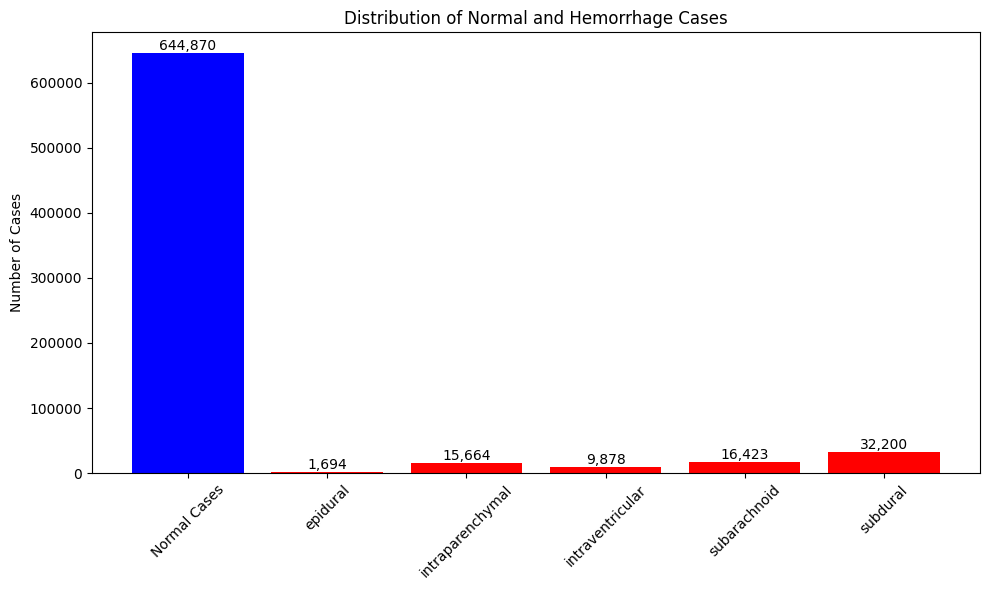

In [7]:
# Plotting
labels = ['Normal Cases'] + hemorrhage_counts.index.tolist()
values = [normal_cases] + hemorrhage_counts.values.tolist()

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['blue'] + ['red']*5)

# Adding the value on top of each bar with thousand separator
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, '{:,.0f}'.format(yval), 
             ha='center', va='bottom')  # Adjust the addition value as per your preference

plt.ylabel('Number of Cases')
plt.title('Distribution of Normal and Hemorrhage Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


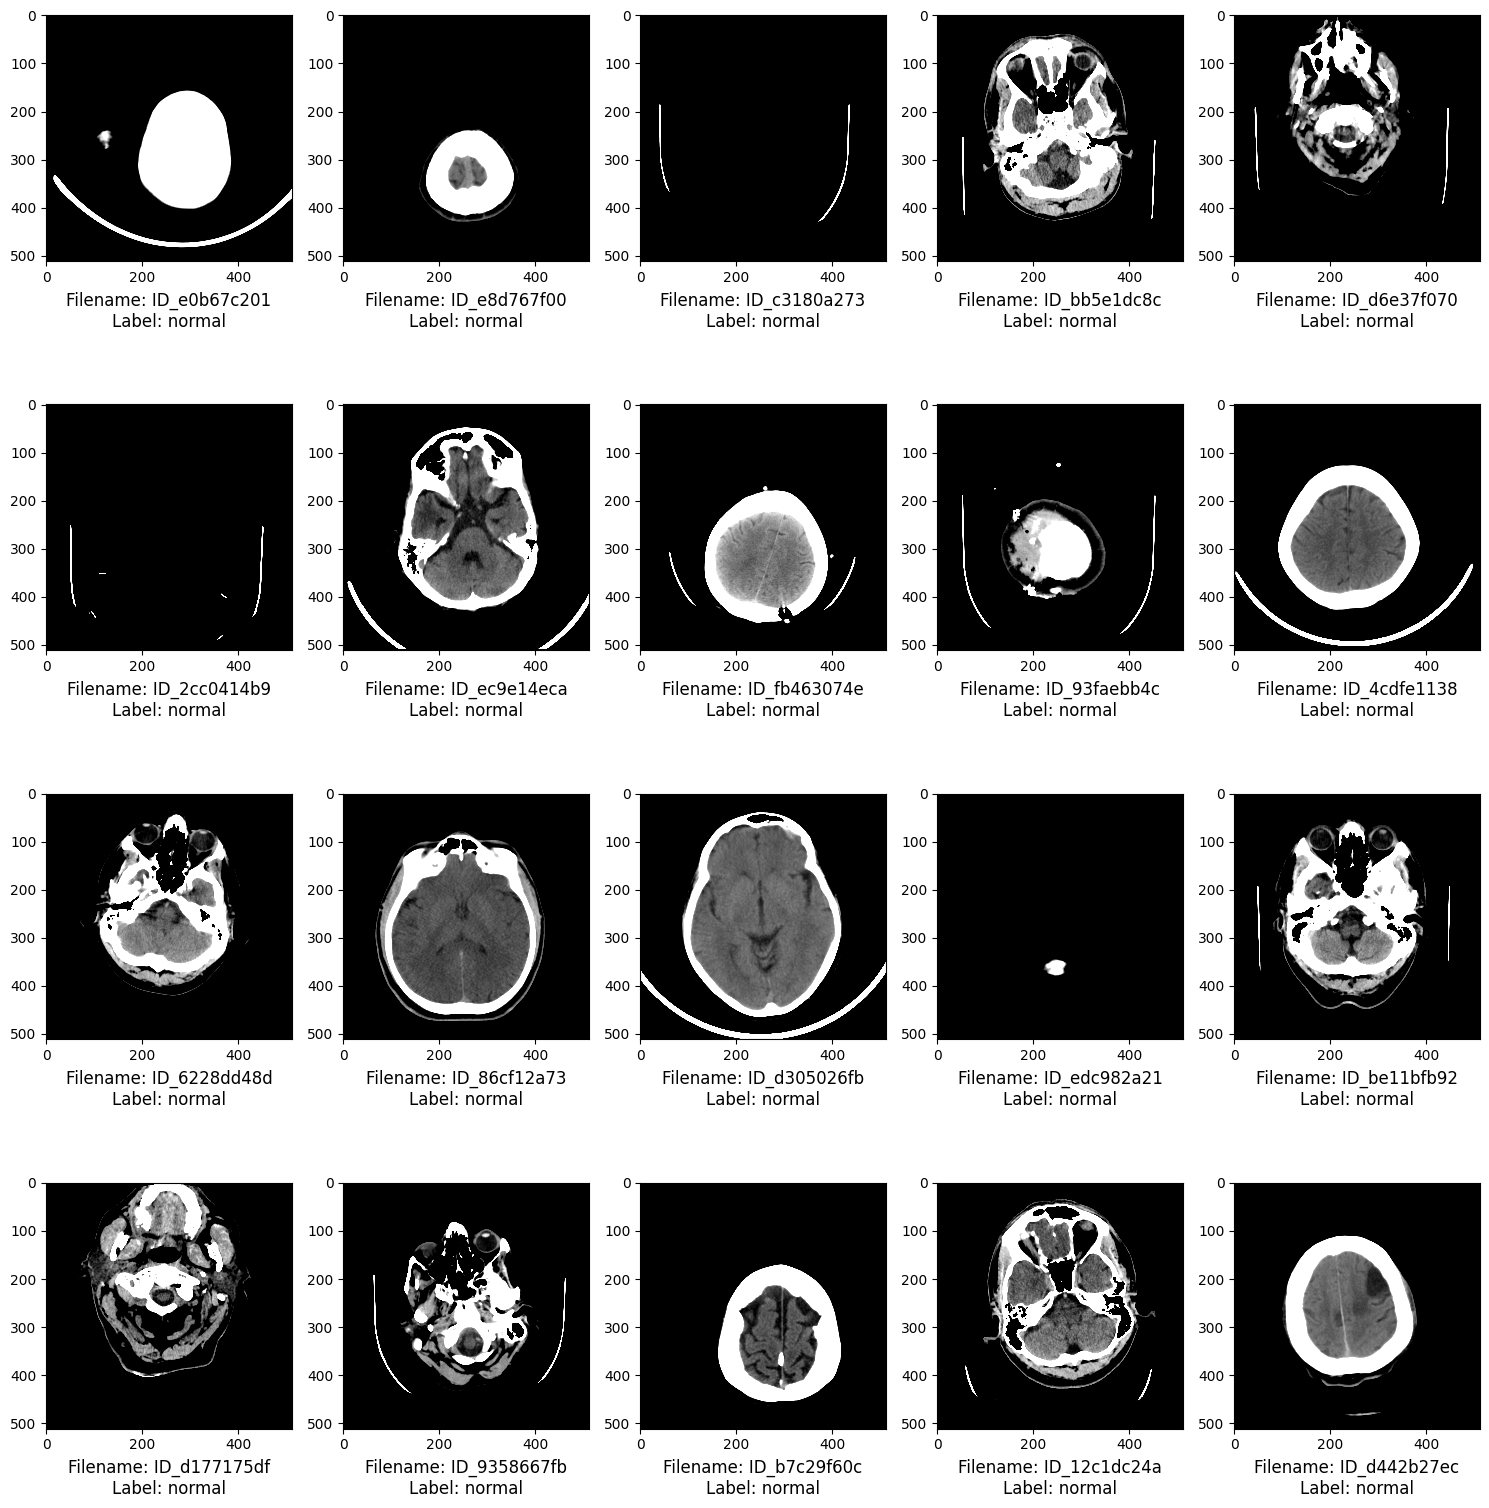

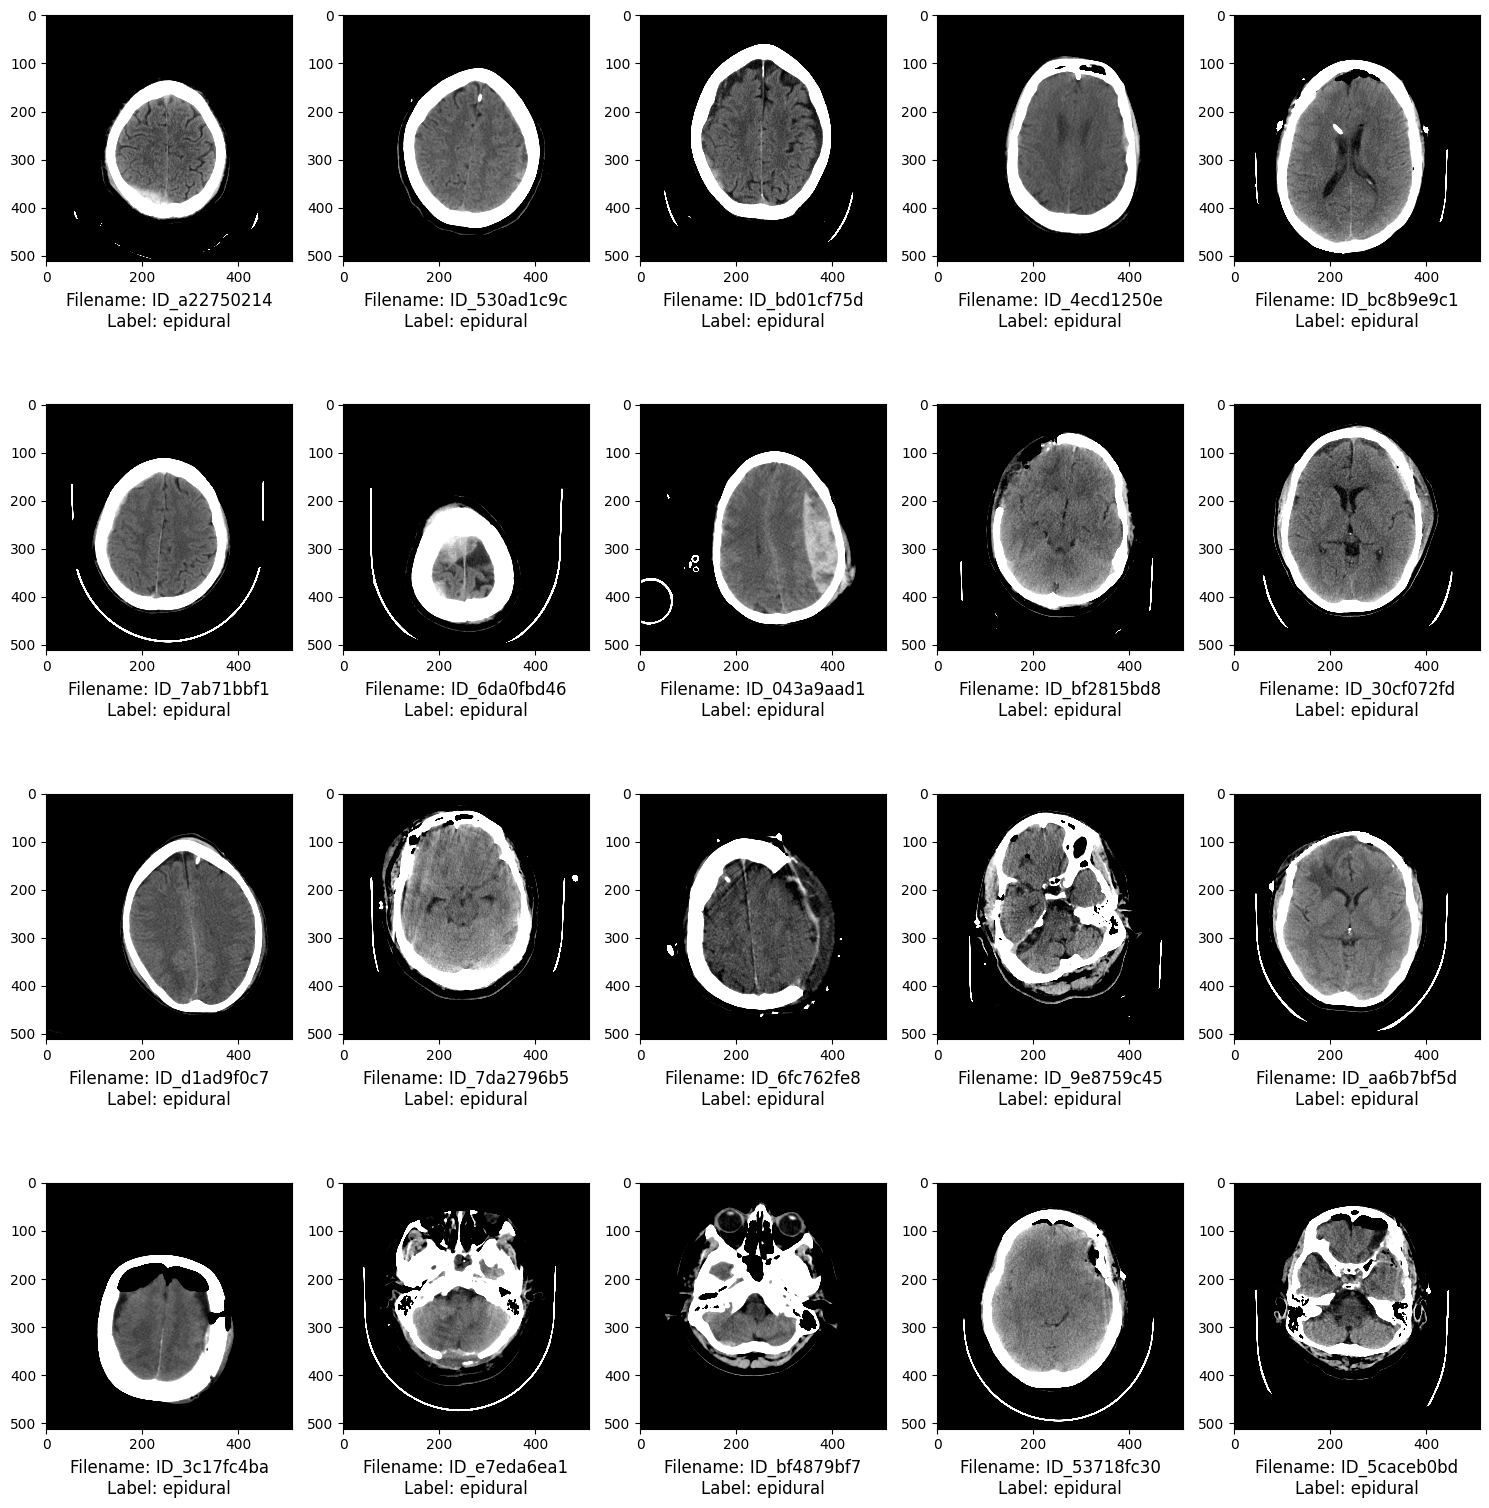

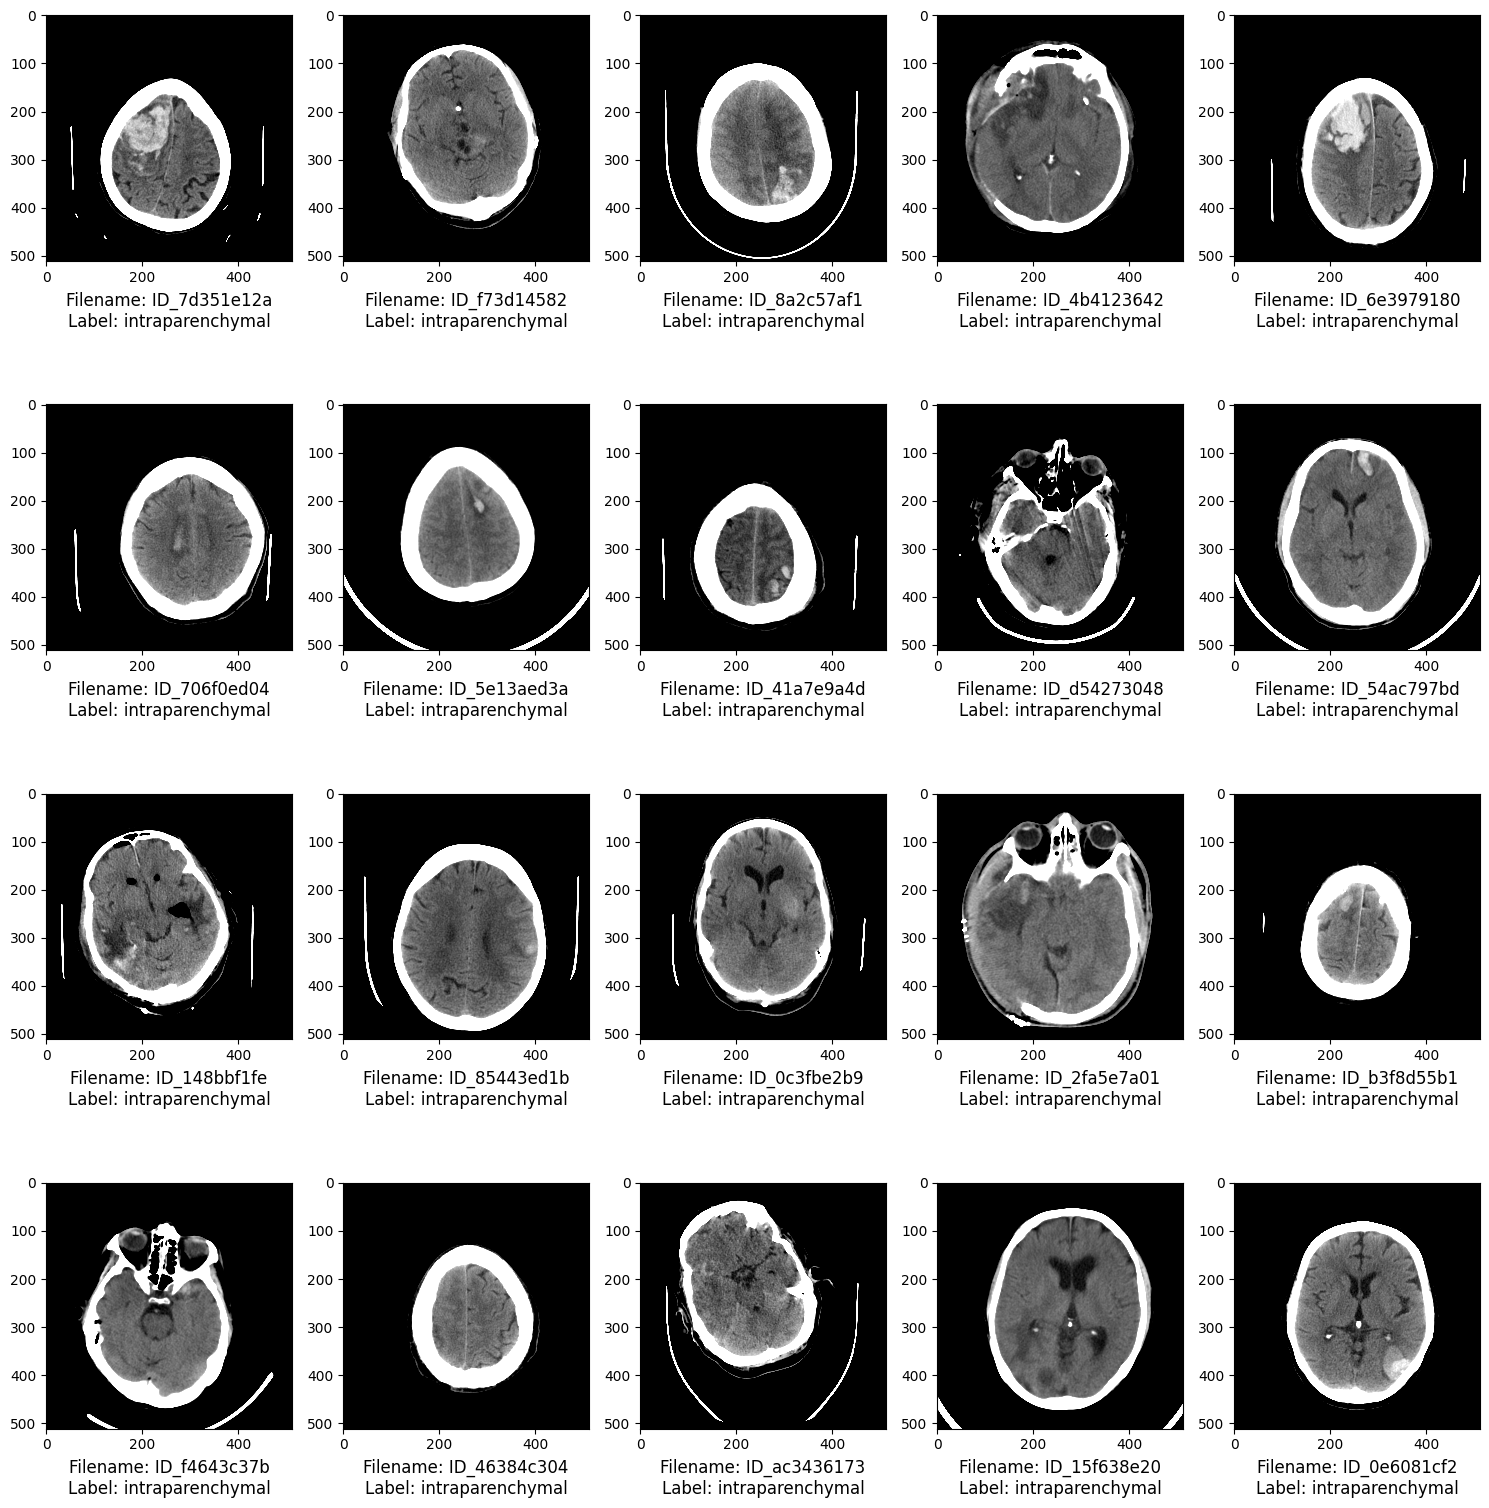

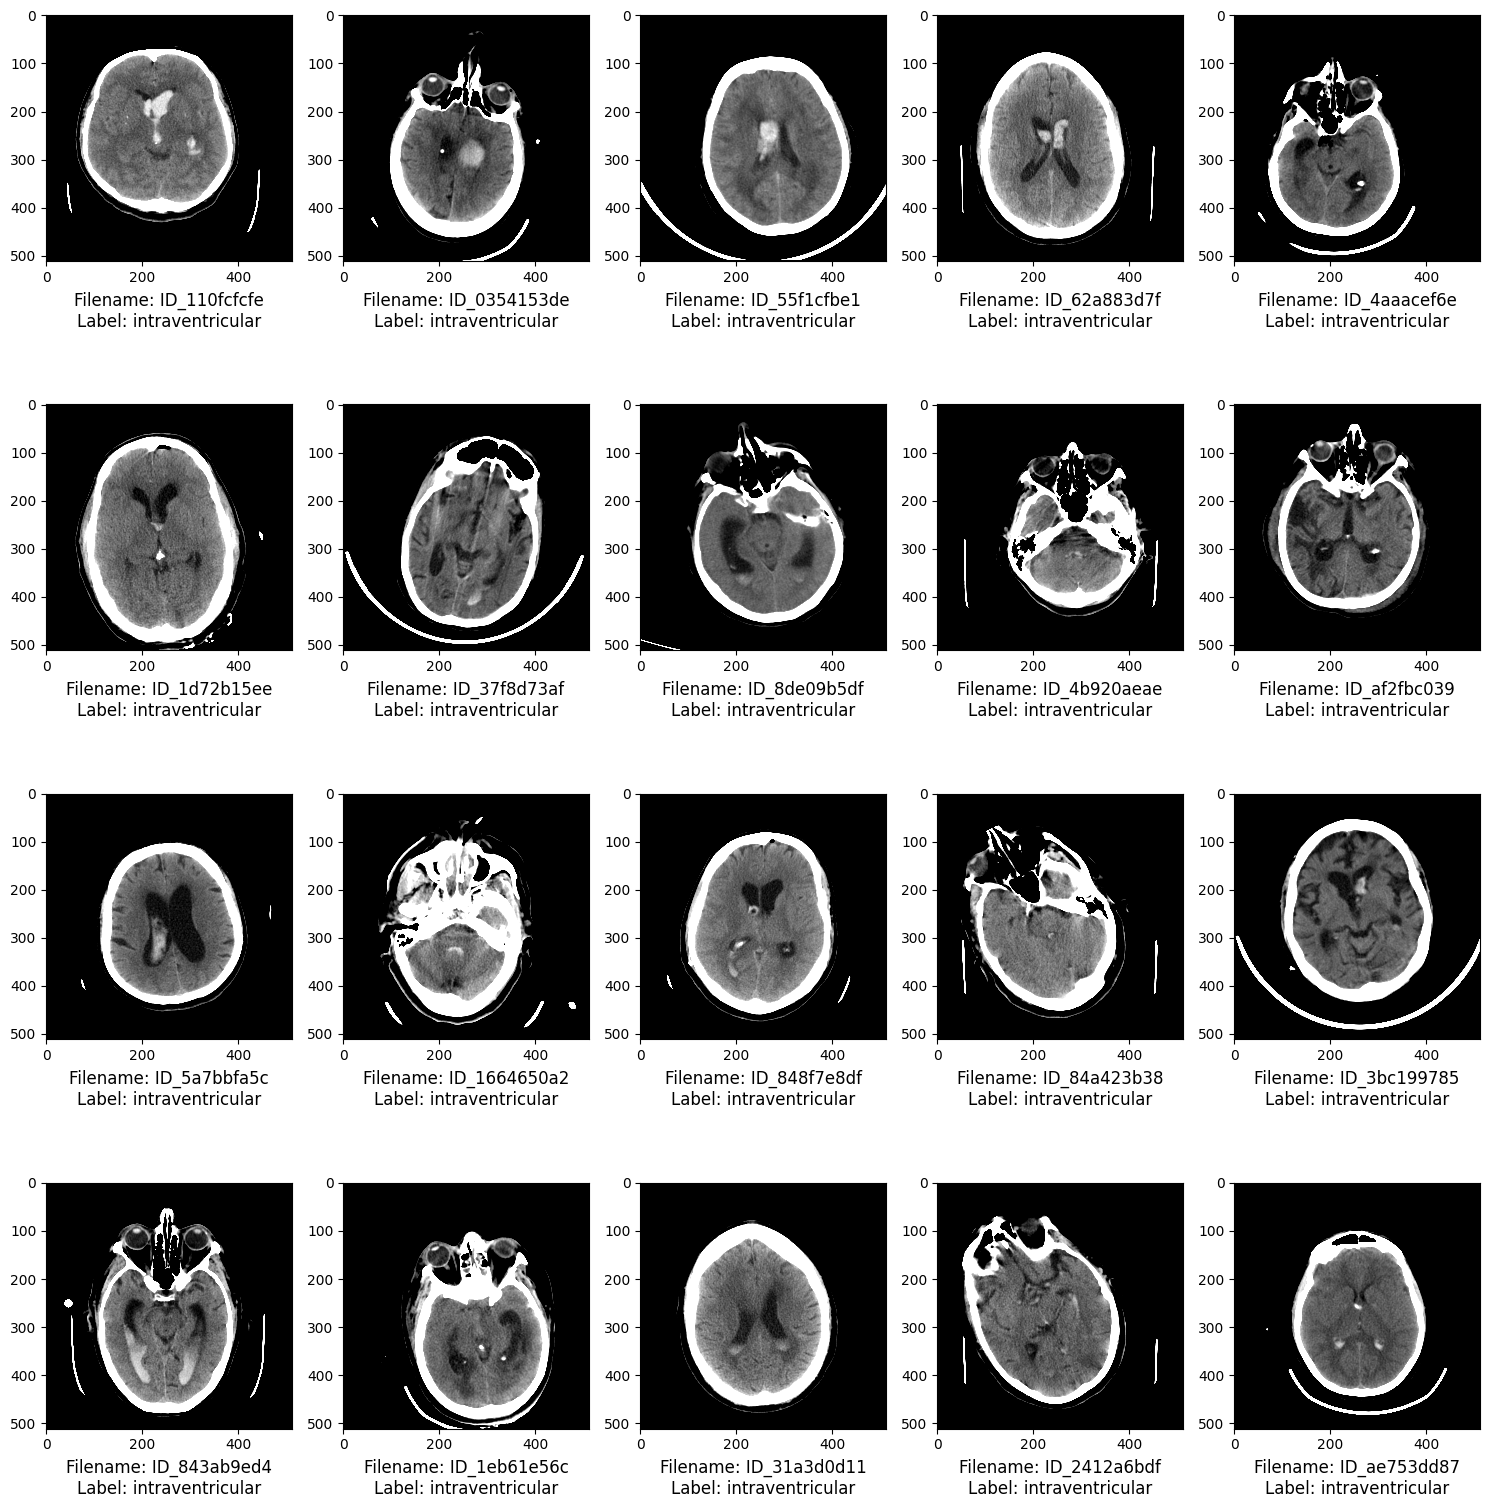

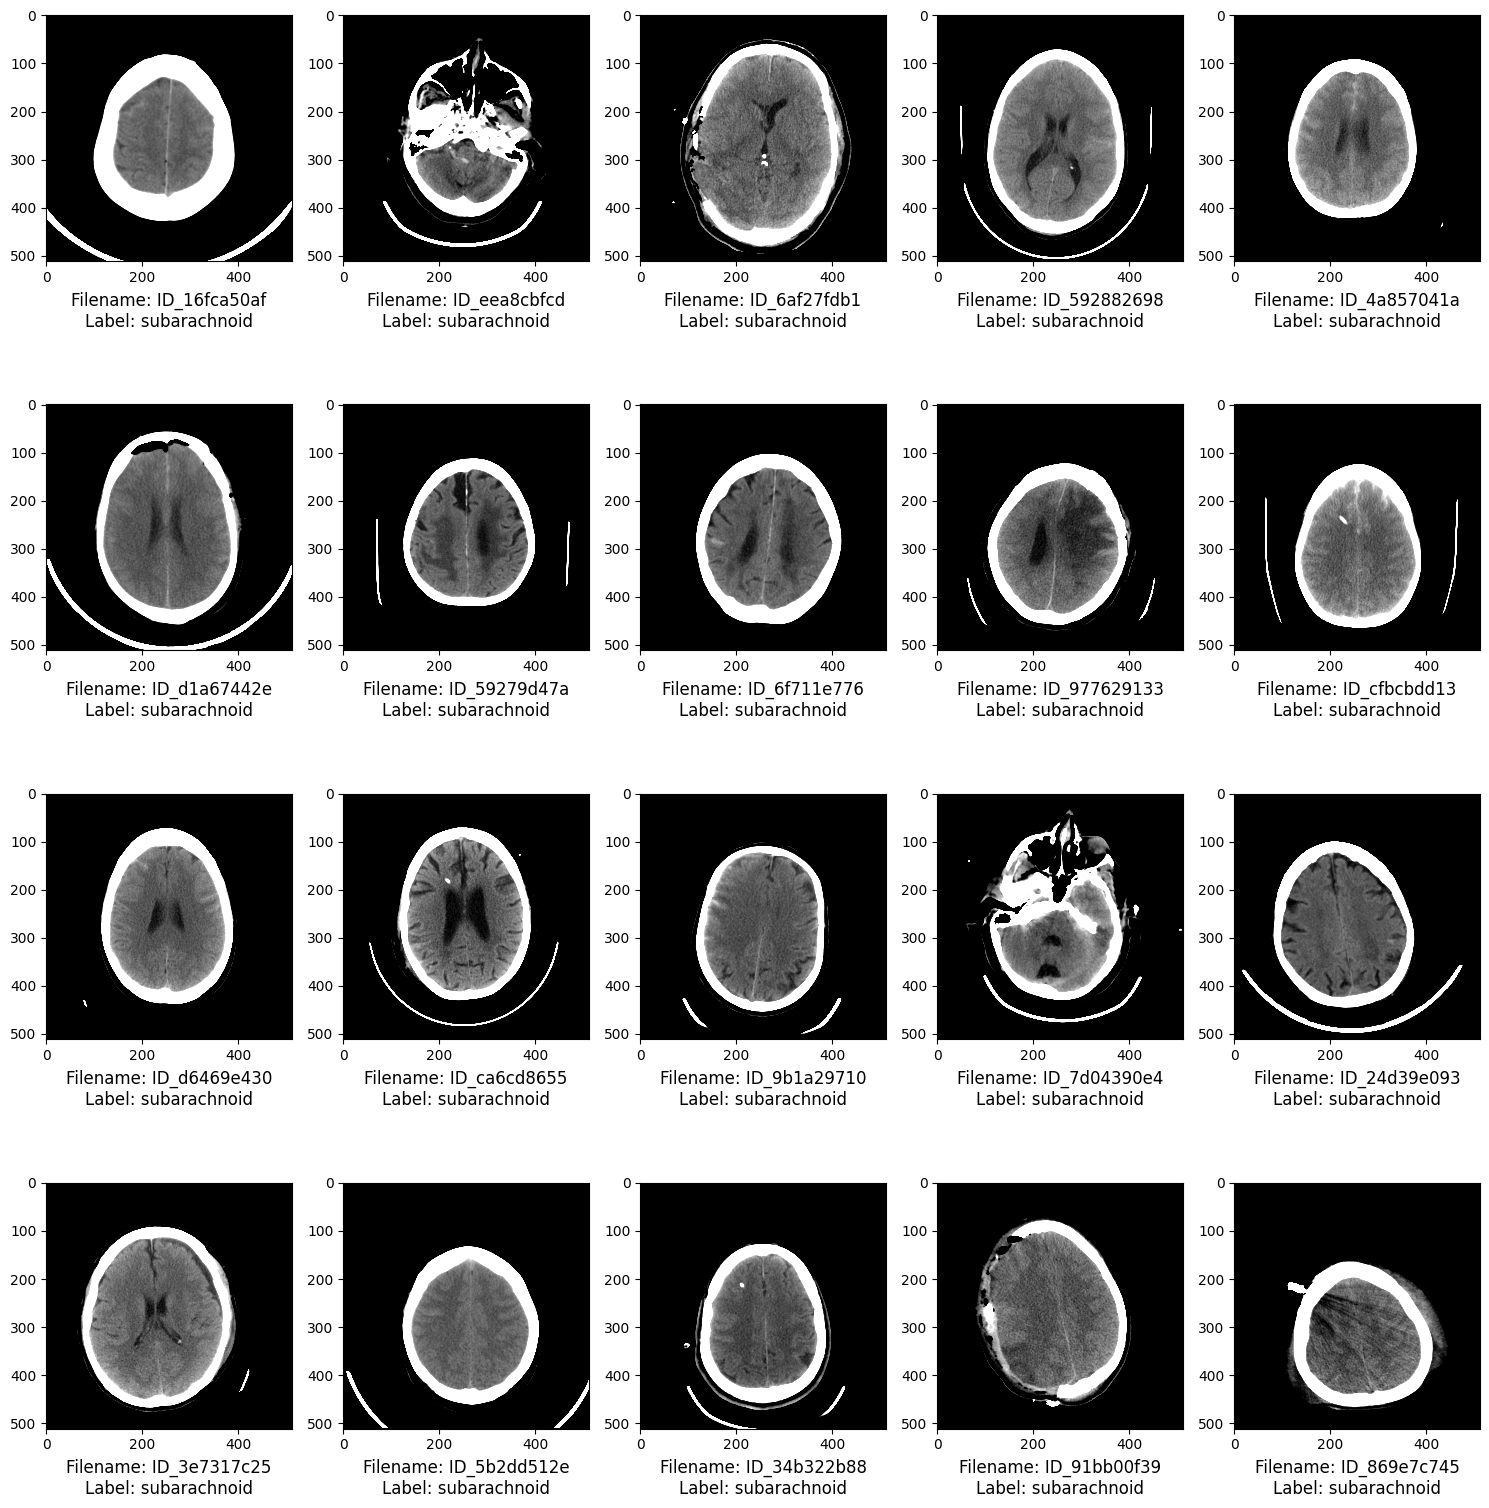

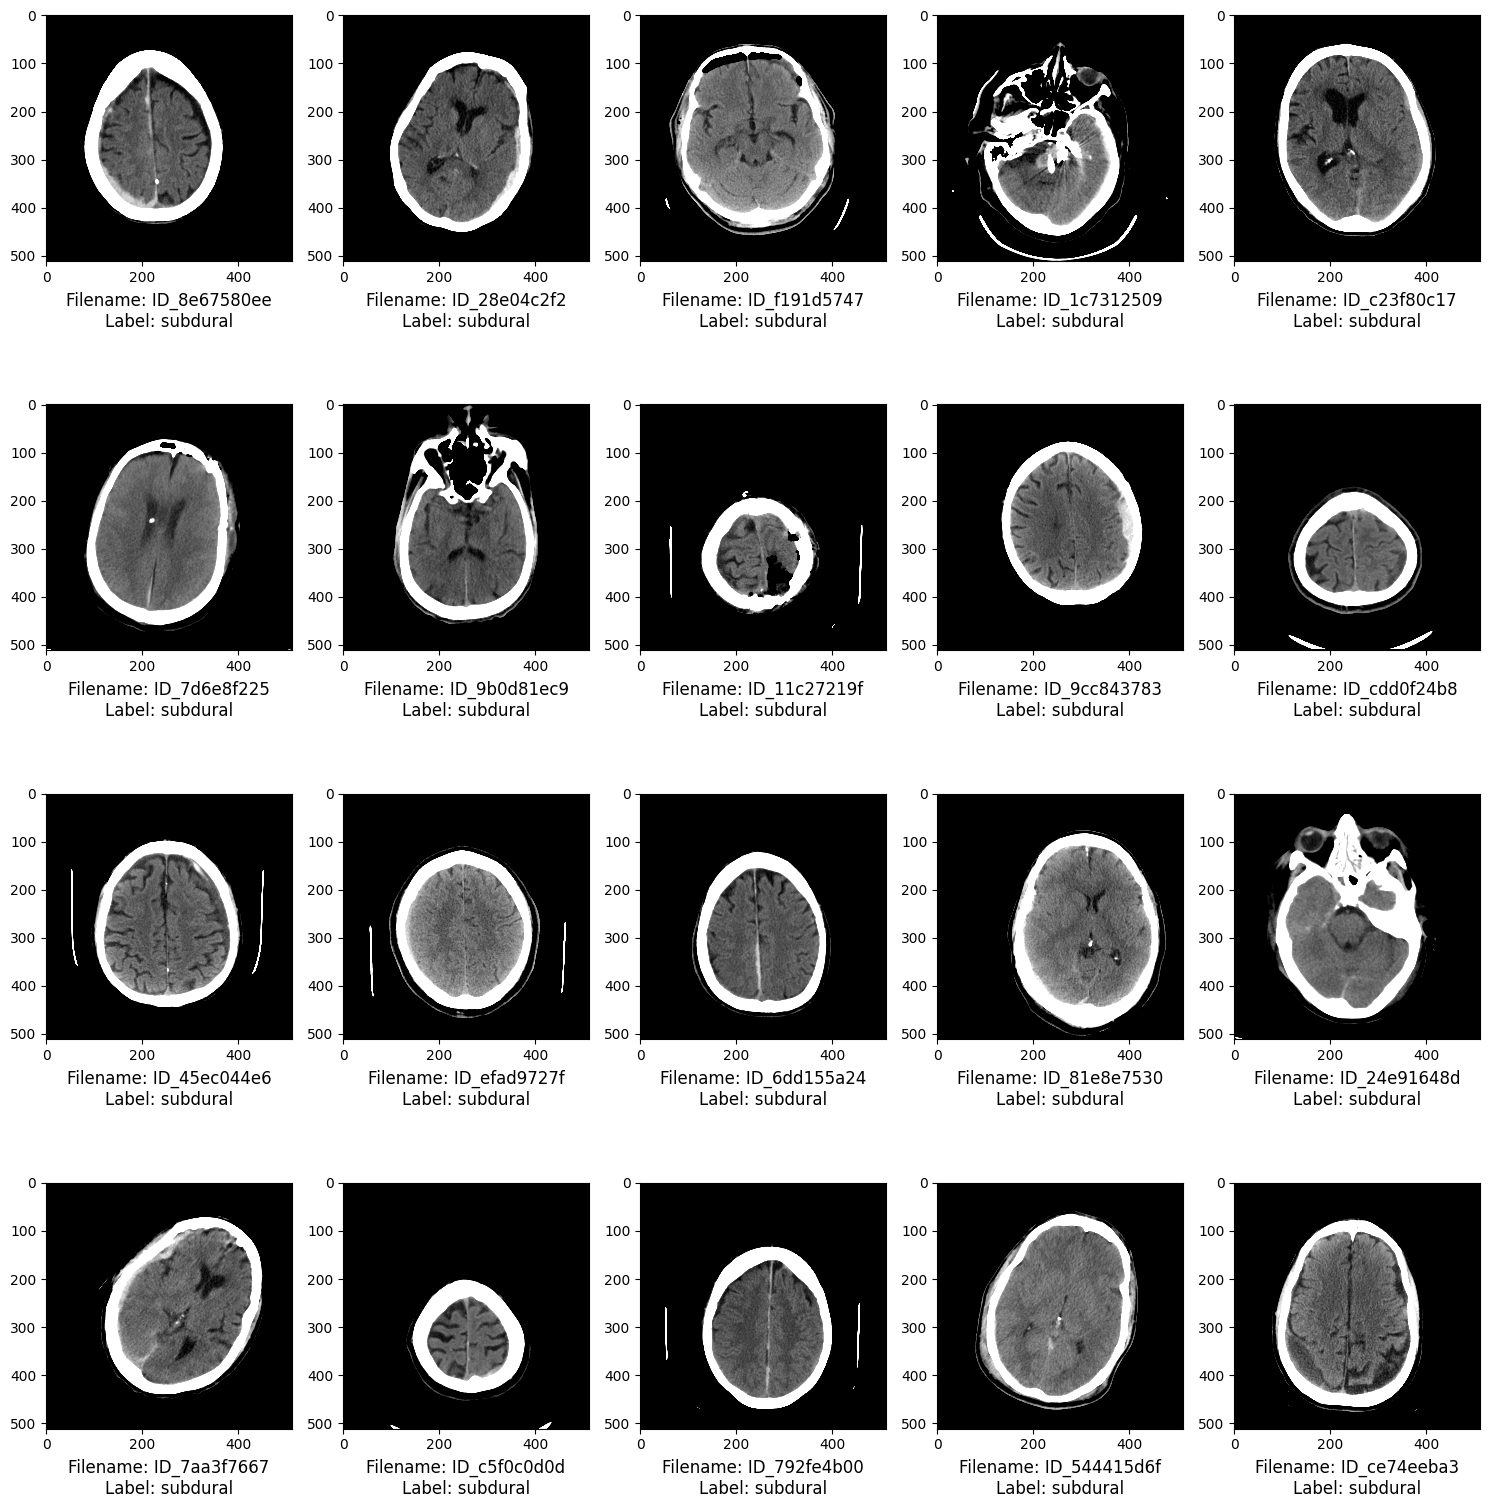

In [8]:
# Visualization function
def windowed_image_display(pixel_array, window_level, window_width):
    vmin = window_level - (window_width / 2)
    vmax = window_level + (window_width / 2)
    plt.imshow(pixel_array, vmin=vmin, vmax=vmax, cmap='gray')


def show_samples_for_label(category, num_samples, columns):
    if category == 'normal':
        samples = df[df[category] == 0].sample(n=num_samples).reset_index()
    else:
        samples = df[df[category] == 1].sample(n=num_samples).reset_index()

    fig = plt.figure(figsize=(15, 4 * num_samples // columns))
    for idx, image_id in enumerate(samples['image_id']):
        ds = pydicom.dcmread(train_images_dir + image_id + '.dcm')
        
        if 'RescaleSlope' in ds:
            slope = float(ds.RescaleSlope)
            intercept = float(ds.RescaleIntercept)
            pixel_array = intercept + ds.pixel_array * slope
        else:
            pixel_array = ds.pixel_array

        ax = fig.add_subplot(num_samples // columns, columns, idx + 1)
        windowed_image_display(pixel_array, 40, 80)
        ax.set_title(f"Filename: {image_id}\nLabel: {category}", y=-0.30)

    plt.tight_layout()
    plt.show()

categories = ['normal', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

for category in categories:
    pass
    print('\n'*3)
    show_samples_for_label(category, 20, 5)



In [9]:
# Define the variables for image exporting
selected_labels = list(df.columns[1:])
#selected_labels = ['normal', 'intraparenchymal']
samples = 500
export_format = 'png'
export_folder = f'dataset_{len(selected_labels)}_classes_{str(samples)}_samples'
testset_name = 'testset'

def window_image(img, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed_img = img.copy()
    windowed_img[img < img_min] = img_min
    windowed_img[img > img_max] = img_max
    return ((windowed_img - img_min) / (img_max - img_min) * 255).astype(np.uint8)

# Setup export folders
if os.path.exists(export_folder):
    shutil.rmtree(export_folder)
os.makedirs(export_folder)
for label in selected_labels + ['testset']:
    os.makedirs(os.path.join(export_folder, label), exist_ok=True)

all_sampled_image_ids = set()

# DICOM handling functions
def read_dicom_image(image_id, directory):
    ds = pydicom.dcmread(directory + image_id + '.dcm')
    if 'RescaleSlope' in ds:
        slope = float(ds.RescaleSlope)
        intercept = float(ds.RescaleIntercept)
        return intercept + ds.pixel_array * slope
    else:
        return ds.pixel_array

def save_image(pixel_array, category, image_id, directory, format):
    windowed_pixel_array = window_image(pixel_array, 40, 80)
    image = Image.fromarray(windowed_pixel_array)
    resized_image = image.resize((224, 224))
    output_filename = os.path.join(directory, category, image_id + '.' + format)
    resized_image.save(output_filename, format=format.upper())

# Exporting labeled samples
for category in selected_labels:
    samples_df = df[df[category] == (0 if category == 'normal' else 1)].sample(n=samples).reset_index()
    all_sampled_image_ids.update(samples_df['image_id'].tolist())
    print(f'Exporting label: {category}')
    for _, image_id in tqdm(samples_df['image_id'].items(), total=samples_df.shape[0]):
        pixel_array = read_dicom_image(image_id, train_images_dir)
        save_image(pixel_array, category, image_id, export_folder, export_format)

# Exporting testset samples
print(f'Exporting label: {testset_name}')
test_samples_per_class = samples // len(selected_labels)
testset_samples_df = pd.DataFrame()
for category in selected_labels:
    remaining_samples_for_class = df[(df[category] == 1) & (~df['image_id'].isin(all_sampled_image_ids))].sample(n=test_samples_per_class)
    testset_samples_df = pd.concat([testset_samples_df, remaining_samples_for_class])
testset_samples_df = testset_samples_df.sample(frac=1).reset_index()
for _, image_id in tqdm(testset_samples_df['image_id'].items(), total=testset_samples_df.shape[0]):
    pixel_array = read_dicom_image(image_id, train_images_dir)
    save_image(pixel_array, testset_name, image_id, export_folder, export_format)

print("Exporting and resizing completed!")

Exporting label: normal


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 222.14it/s]


Exporting label: epidural


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 262.33it/s]


Exporting label: intraparenchymal


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 243.65it/s]


Exporting label: intraventricular


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 226.86it/s]


Exporting label: subarachnoid


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 230.41it/s]


Exporting label: subdural


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 220.84it/s]


Exporting label: testset


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [00:02<00:00, 233.46it/s]

Exporting and resizing completed!
